In [23]:
import cv2
import numpy as np
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

from keras.models import *
from keras.layers import *

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:

# _URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz'

# path_to_zip = tf.keras.utils.get_file('edges2shoes.tar.gz',
#                                       origin=_URL,
#                                       extract=True)

PATH = ('Skin_data/')

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]
    real_image =tf.image.rgb_to_grayscale(real_image)
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

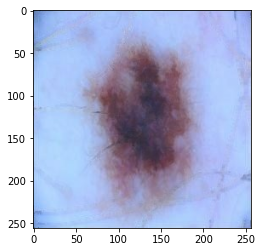

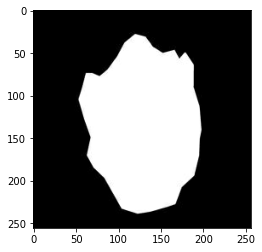

In [5]:
inp, re = load(PATH+'train_hair_removed/ISIC_0000042.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0, cmap = 'gray')

In [6]:
def resize(input_image, real_image, height, width):
    
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
    pass
#   stacked_image = tf.stack([input_image, real_image], axis=0)
#   cropped_image = tf.image.random_crop(
#       stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

#   return cropped_image[0], cropped_image[1]


In [8]:
def normalize(input_image, real_image):
    
    input_image = (input_image / 255.0)
    real_image = (real_image / 255.0)
    
    return input_image, real_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
#   # resizing to 286 x 286 x 3
#   input_image, real_image = resize(input_image, real_image, 286, 286)

#   # randomly cropping to 256 x 256 x 3
#   input_image, real_image = random_crop(input_image, real_image)

#   if tf.random.uniform(()) > 0.5:
#     # random mirroring
#     input_image = tf.image.flip_left_right(input_image)
#     real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

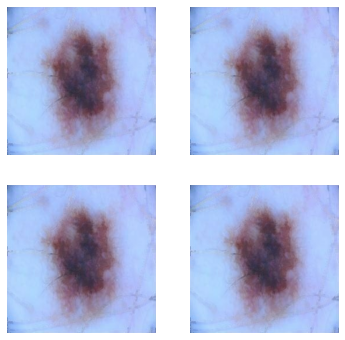

In [10]:
plt.figure(figsize=(6, 6))

for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [11]:
def load_image_train(image_file):
    
    input_image, real_image = load(image_file)
    input_image, real_image = normalize(input_image, real_image)
    
#     input_image, real_image = random_jitter(input_image, real_image)
    
    return input_image, real_image

In [12]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files(PATH+'train_hair_removed/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.list_files(PATH+'test_hair_removed/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
OUTPUT_CHANNELS = 1

In [16]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [17]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [18]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [19]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [20]:
# Modified U-net Architecture

# from tensorflow.keras.models import Model

# def Generator():
#   inputs = tf.keras.layers.Input(shape=[256,256,3])

#   down_stack = [
#     downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
#     downsample(128, 4), # (bs, 64, 64, 128)
#     downsample(256, 4), # (bs, 32, 32, 256)
#     downsample(512, 4), # (bs, 16, 16, 512)
#     downsample(512, 4), # (bs, 8, 8, 512)
#     downsample(512, 4), # (bs, 4, 4, 512)
#     downsample(512, 4), # (bs, 2, 2, 512)
#     downsample(512, 4), # (bs, 1, 1, 512)
#   ]

#   up_stack = [
#     upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
#     upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
#     upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
#     upsample(512, 4), # (bs, 16, 16, 1024)
#     upsample(256, 4), # (bs, 32, 32, 512)
#     upsample(128, 4), # (bs, 64, 64, 256)
#     upsample(64, 4), # (bs, 128, 128, 128)
#   ]

#   initializer = tf.random_normal_initializer(0., 0.02)
#   last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2,
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='sigmoid') # (bs, 256, 256, 3)

#   x = inputs

#   # Downsampling through the model
#   skips = []
#   for down in down_stack:
#     x = down(x)
#     skips.append(x)

#   skips = reversed(skips[:-1])

#   # Upsampling and establishing the skip connections
#   for up, skip in zip(up_stack, skips):
#     x = up(x)
#     x = tf.keras.layers.Concatenate()([x, skip])

#   x = last(x)

#   return tf.keras.Model(inputs=inputs, outputs=x)

In [26]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    return tf.keras.Model(inputs=inputs, outputs=conv10)

In [27]:
generator = Generator()
generator.summary()

The following Variables were used a Lambda layer's call (tf.nn.convolution_24), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_24/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_24), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_24/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_25), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_25/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is inten

The following Variables were used a Lambda layer's call (tf.nn.bias_add_34), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_34/bias:0' shape=(512,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_35), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_35/kernel:0' shape=(3, 3, 1024, 512) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_35), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_35/bias:0' shape=(512,) dtype=float32>
It is possible that this is intended beha

The following Variables were used a Lambda layer's call (tf.nn.convolution_45), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_45/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_45), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_45/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_46), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_46/kernel:0' shape=(3, 3, 64, 2) dtype=float32>
It is possible that this is inten

__________________________________________________________________________________________________
tf.image.resize_5 (TFOpLambda)  (None, 64, 64, 512)  0           tf.nn.relu_35[0][0]              
__________________________________________________________________________________________________
tf.nn.convolution_37 (TFOpLambd (None, 64, 64, 256)  0           tf.image.resize_5[0][0]          
__________________________________________________________________________________________________
tf.nn.bias_add_37 (TFOpLambda)  (None, 64, 64, 256)  0           tf.nn.convolution_37[0][0]       
__________________________________________________________________________________________________
tf.nn.relu_36 (TFOpLambda)      (None, 64, 64, 256)  0           tf.nn.bias_add_37[0][0]          
__________________________________________________________________________________________________
tf.concat_5 (TFOpLambda)        (None, 64, 64, 512)  0           tf.nn.relu_28[0][0]              
          

In [ ]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()
discriminator.summary()

In [ ]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
#     tar1 = tar[0].numpy()
#     pred1 = prediction[0].numpy()
#     y_true_f = abs(tar1.flatten())
#     y_pred_f = abs(pred1.flatten())
#     union = np.sum(y_true_f) + np.sum(y_pred_f)
#     cp=round(abs(np.sum(pred1>0)))
#     co=round(abs(np.sum(tar1>0)))
    
   
#     y_true_f[y_true_f<0] = 0
#     co = round(np.sum(y_true_f))
#     print(co)
    
#     y_pred_f[y_pred_f<0] = 0
#     cp = round(np.sum(y_pred_f))
#     print(cp)
    
#     df=abs(cp-co)
#     rt=(1-df/co)
#     print(rt * 100)
    
    
#     if union==0: return 1
    
#     intersection = np.sum(y_true_f * y_pred_f)
#     acc = 2. * intersection / union
    
#     print("IOU score: ", np.count_nonzero(y_pred_f == 1))
  
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

In [ ]:
for example_input, example_target in test_dataset.take(1):
    z = generate_images(generator, example_input, example_target)
 

In [ ]:
EPOCHS = 75

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
    return gen_total_loss, disc_loss



In [ ]:
global gen_lo
gen_lo = [0]

global disc_lo
disc_lo = [0]

In [ ]:
def fit(train_ds, epochs, test_ds):
    
    for epoch in range(epochs):
        start = time.time()
        
        display.clear_output(wait=True)
        
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        
        print("Epoch: ", epoch)
        
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            
            if (n+1) % 20 == 0:
                print()
            
            ge, di = train_step(input_image, target, epoch)
            gen_lo.append(ge.numpy())
            disc_lo.append(di.numpy())
        
        print("generator: ", gen_lo)
        print("discriminator: ", disc_lo)
        
        
        print()
        
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
               
    checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
len(disc_lo)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score   


In [ ]:
def generate_image(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    

    tar1 = tar[0].numpy()
    tar1[tar1<0.5] = 0
    tar1[tar1>0.5] = 1
    tar1 = np.abs(tar1)
    
    pred1 = prediction[0].numpy()
    pred1[pred1<0.5] = 0
    pred1[pred1>0.5] = 1
    pred1 = np.abs(pred1)
    y_true = tar1.flatten()
    y_pred = pred1.flatten()
 
    union = np.sum(y_true) + np.sum(y_pred)
    
    if union==0: return 1
    
    intersection = np.sum(y_true * y_pred)
    acc = 2. * intersection / union
        

    global seg_iou
    global seg_acc_value
    global seg_f1_value
    global seg_jac_value
    global seg_recall_value
    global seg_precision_value

    seg_iou = acc
    
    seg_acc_value = acc_value = accuracy_score(y_true, y_pred)
    seg_f1_value = f1_value = f1_score(y_true, y_pred, labels=[0, 1], average="binary")
    seg_jac_value = jac_value = jaccard_score(y_true, y_pred, labels=[0, 1], average="binary")
    seg_recall_value = recall_value = recall_score(y_true, y_pred, labels=[0, 1], average="binary")
    seg_precision_value = precision_value = precision_score(y_true, y_pred, labels=[0, 1], average="binary")
    
    seg_iou = acc    

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(display_list[i], cmap= 'gray')
#         plt.imshow(display_list[i])
        plt.axis('off')
    
    plt.show()

In [ ]:
iou_mean = []
acc_mean = []
f1_mean = []
jac_mean = []
recall_mean = []
precision_mean = []

# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(110):
    generate_image(generator, inp, tar)
    iou_mean.append(seg_iou)
    acc_mean.append(seg_acc_value)
    f1_mean.append(seg_f1_value)
    jac_mean.append(seg_jac_value)
    recall_mean.append(seg_recall_value)
    precision_mean.append(seg_precision_value)


In [ ]:
from numpy import mean
print(mean(iou_mean))
print(mean(acc_mean))
print(mean(f1_mean))
print(mean(jac_mean))
print(mean(recall_mean))
print(mean(precision_mean))